# Predicting the difference of ERA5 & NZRA

Past experiments have collapsed to the mean - i.e. the ConvNP just produces the annual mean temperature, curdely minimizing the loss without learning anything useful. By training on the difference of ERA5 & NZRA as the target, hopefully the ConvNP will be encouraged to learn the relationship between stations + ERA5 to NZRA.

#### Context Sets
1. Gridded context: ERA5, sun position.
2. Offgrid context: Ground station observations.
3. Auxiliary: Topography, x1x2 encoding, land/sea mask.

#### Target Sets:
1. The difference between ERA5 & NZRA, sampled at random locations.

## Running this notebook

Like experiment 4, this notebook is run in either 'dataset generation' mode, or 'training' mode. These modes are controlled with environmental variable `DATASET_GENERATION`. Setting `DATASET_GENERATION = "1"` enables dataset generation, while setting it to `"0"` enables model training. Training a model requires dataset generation to be completed and saved to the disk first.

Datasets are saved to the disk using the 'pickle' library. This essentially turns python objects into a file which can be re-loaded into a python object later. Here, we 'pickle' the deepsensor tasks, and save each one as a file to the disk. The filepaths are set in the `.env` file. Training and validation sets are generated. We do this because loading terabytes or netcdf data into a python list is not feasable, but that is how deepsensor is set up. These files are loaded in batch-by-batch while model training, in the function `train_epoch_pickled`. There is plenty of scope for future work here:
- Saving a custom file format (potentially netcdf backed?) which can be reconstructed to a deepsensor task. This would be more efficient than pickling tasks.
- Bringing the modified `train_epoch_pickled` task into the custom deepsensor distribution.

### Custom neuralprocesses & deepsensor distributions
I have modified neuralprocesses & deepsensor. These are kept in a fork on my github: *lennoxc/neuralprocesses* and *lennoxc/deepsensor*.

##### Deepsensor modifications:
- The `loss_fn()` function can be passed a *float* parameter `edge_margin` which ignores the edge margin around tasks when calculating the loss. The zero padding was causing issues around the edges of the tasks, increasing the loss, and therefore increasing the models "focus" on the edges. This created unstable training. Passing `edge_margin = receptive_field//2` seems to work well. As of 03/02/2026 this is only supported for off-grid targets, but I will make sure to expand this to gridded targets, and multi-variate targets over the next week or so.
- I removed a buggy warning message from `processor.py` which threw an exception when warning that the lat/lon grid has different ranges (and therefore isn't square). The warning still exists, but doesn't try to calculate the difference between the two dimensions. This buggy warning was stopping notebook execution when really only a warning should be thrown.
- Added support for creating a model with dropout. See the neuralprocesses modification I made too.
- I am planning of migrating some other code from this repo to my custom deepsensor distribution for cleanliness.

##### Neuralprocesses modifications:
- I added support for dropout for the ConvNP class. By default the dropout rate is 0.0 (i.e. disabled) but this may be useful when encountering overfitting. I haven't had to use this yet.

Provided you use/recreate the provided .pixi environment, deepsensor and neuralprocesses will pull from my fork, rather than the main libraries. Updates from deepsensor and neuralprocesses will need to be merged into my fork to keep it up-to-date!

### Notebook execution

Here's what this notebook does:
1. imports/hyperparameters/environment setup
2. load datasets using the API provided in this repository
3. pre-processes each dataset. Lots of this is the same across all experiments, but sometimes modifications might be made to the pre-processing between experiments.
4. perform visualisation on each set. This is useful for debugging.
5. filter each dataset to specifically the fields used for the following experiment.
6. generate a data processor & task loader. If it is the first time running in the experiment directory (set in the pbs script) then new normalisation parameters are calcualted, using a sample of the tasks. This is important to prevent data-leakage and changing normalisation parameters at training/inference time.
7. If required: generate and save the dataset to the disk.
8. Start model training!

## Experiment Setup
- do imports
- set up project wide settings, variables, hyperparameters

In [4]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# imports from this repo
%autoreload 2
from convcnp_assim_nz.config.logging_config import setup_logging
from convcnp_assim_nz.config.env_loader import use_absolute_filepaths, get_env_var
from convcnp_assim_nz.utils.variables.var_names import TEMPERATURE, PRECIPITATION, SURFACE_PRESSURE, HUMIDITY, WIND_SPEED, WIND_DIRECTION, WIND_U, WIND_V, VERTICAL_VELOCITY, GEOPOTENTIAL, SUN_CULMINATION, SUN_ANGLE, SEA_SURFACE_TEMPERATURE, TEMPERATURE_MIN, TEMPERATURE_MAX, SHORTWAVE_FLUX_DOWN, BAND_3, BAND_9, BAND_13, ELEVATION, TOPOGRAPHIC_POSITION_INDEX, LAND_SEA_MASK
from convcnp_assim_nz.utils.variables.coord_names import LATITUDE, LONGITUDE, TIME
from convcnp_assim_nz.data_processing.nzra_processor import ProcessNZRA
from convcnp_assim_nz.data_processing.topography_processor import ProcessTopography
from convcnp_assim_nz.data_processing.himawari8_processor import ProcessHimawari8
from convcnp_assim_nz.data_processing.era5_processor import ProcessERA5
from convcnp_assim_nz.data_processing.station_processor import ProcessStations
from convcnp_assim_nz.data_processing.conversions.scalar_conversions import kelvin_to_celsius
from convcnp_assim_nz.data_processing.auxiliary.sun_position import get_sun_culmination, get_sun_position
from convcnp_assim_nz.learning.model_training import train_epoch_pickled, compute_val_loss_pickled, return_sample_predictions

Loading environment variables from: /esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/.env


In [3]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import deepsensor.torch
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from mpl_toolkits.basemap import Basemap
import pickle
import logging
from datetime import datetime
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device, concat_tasks
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.data.utils import construct_x1x2_ds
from deepsensor.data.utils import compute_xarray_data_resolution, compute_pandas_data_resolution


In [5]:
os.environ["HOSTNAME"]

'xd225v051.slv.hpc.niwa.co.nz'

In [6]:
# setup logging
setup_logging()  # configure logging
logger = logging.getLogger(__name__)
logger.info("Notebook execution started.")

# these are only used when the environment variables are not set - i.e. when debugging on a jupyter kernel
DEV_DEFAULT = "1"
DATASET_GEN_DEFAULT = "0"

# settings: development mode and dataset generation mode
dev = True if os.getenv("DEVELOPMENT_ENVIRONMENT", DEV_DEFAULT) == "1" else False
dataset_generation = True if os.getenv("DATASET_GENERATION", DATASET_GEN_DEFAULT) == "1" else False

# CUDA & filepath setup
logger.info(f"CUDA available: {torch.cuda.is_available()}")
if not os.environ["HOSTNAME"] in [
    'hub-worker01', 
    'hub-worker02', 
    'login01.slv.hpc.niwa.co.nz',
    'xd225v051.slv.hpc.niwa.co.nz'
    ] and not dataset_generation: # no GPU available on jupyter node. Dataset generation always on CPU
    set_gpu_default_device()

use_absolute_filepaths(True)

# setup tensorboard
TB_BASE = "/home/crowelenn/dev/convcnp-assim-nz"
TB_EXPERIMENT = "experiment4"

if dev:
    TB_PREFIX = "debug_runs"
else:
    TB_PREFIX = "runs"

EXPERIMENT_NAME = os.getenv("EXPERIMENT_NAME", "default_experiment")

# tensorboard tags
TB_TRAIN_LOSS = "Loss/Train"
TB_VAL_LOSS = "Loss/Validation"
TB_RUN_LOGS = "Run/Steps"
TB_EXAMPLE_TASK = "Tasks/Example"
TB_CUDA_MEM = "System/CUDA_Memory_MB"
TB_PREDICTIONS_TRAIN_PLOT = "Predictions/Train"
TB_PREDICTIONS_VAL_PLOT = "Predictions/Validation"
TB_LEARNING_RATE = "Hyperparameters/Learning_Rate"

if not dev:
    tb_path = os.path.join(TB_BASE, ".tensorboard", TB_EXPERIMENT, TB_PREFIX, f"run_{datetime.now().strftime('%d-%m-%YT%H:%M:%S')}")

    tb_writer = SummaryWriter(log_dir=tb_path)

2026-02-12 00:57:43 - INFO - __main__ - Notebook execution started.
2026-02-12 00:57:43 - INFO - __main__ - CUDA available: False


### Hyperparameters

In [7]:
# DATASET HYPERPARAMETERS

# variables for this experiment. 2017 will be saved for testing
years = [2013, 2014, 2015, 2016] # this gets modified later if PROCESS_YEAR is set
all_years = years.copy() # this needs to be kept

target_variable = [TEMPERATURE]

# if the target variable is not a list, make it one
if not isinstance(target_variable, list):
    target_variable = [target_variable]

target_variable_diff = [f"{var}_diff" for var in target_variable]

# exclude the first and last day of each year - occasionally have incomplete data on these days
# this is minimal data loss and avoids issues with incomplete data
time_slice = slice(f'{min(years)}-01-02T00:00:00', f'{max(years)}-12-30T23:00:00')

# you can set PROCESS_YEAR when running this notebook to only process a single year
# this allows parallelising dataset generation across multiple notebook runs
process_year = 2013
if os.getenv("PROCESS_YEAR") is not None and int(os.getenv("PROCESS_YEAR")) in years:
    process_year = int(os.getenv("PROCESS_YEAR"))
    years = [process_year]
    time_slice = slice(f'{process_year}-01-02T00:00:00', f'{process_year}-12-30T23:00:00')

if min(years) < 2017:
    load_himawari = False
else:
    load_himawari = True

TOPO_COARSEN = 2
H8_COARSEN = 2

NORM_SIZE = 100
TRAIN_SPLIT = 0.7 # 0.8 = 80% training, 20% validation

# LEARNING HYPERPARAMETERS
N_EPOCHS = 75
LR = 1e-4
BATCH_SIZE = 8
VAL_EVERY = 5
CHECKPOINT_EVERY = 50
UNET_CHANNELS = (32, 64, 128)
INTERNAL_DENSITY = 1111 // 2 # reduced from 1997 (from stations resolution)
INITIAL_NOISE = 1e-4
UNFIX_NOISE_AT_EPOCH = 0
TARGET_SAMPLING_COUNT = 1000 # not used when SAMPLING_STRATEGY is "all"
SAMPLING_STRATEGY = "all" # this overrides TARGET_SAMPLING_COUNT, and just samples all points

USE_GRAD_CLIP = False
GRAD_CLIP_VALUE = 1.0
EFFECTIVE_BATCH_SIZE = 48
GRAD_ACCUM_STEPS = EFFECTIVE_BATCH_SIZE // BATCH_SIZE

# override some hyperparameters for dev environment
if dev:
    years = [2016]

    time_slice = slice(f'{min(years)}-01-02T00:00:00', f'{max(years)}-01-27T23:00:00')
    #time_slice = slice(f'{min(years)}-01-02T00:00:00', f'{min(years)}-02-30T23:00:00')
    SAMPLING_STRATEGY = "sample"
    NORM_SIZE = 100 # smaller norm size for dev

    N_EPOCHS = 5
    VAL_EVERY = 1

    INTERNAL_DENSITY = 1111 // 2
    INITIAL_NOISE = 5e-2
    UNFIX_NOISE_AT_EPOCH = 0

if not dev and not dataset_generation:
    # prod training.
    # we will reduce the time range for generating the norm_task_loader so we can run this with low memory
    # this will still train the model on the full dataset, and the norm_task_loader will fetch pre-computed norm params anyway.

    time_slice = slice(f'{min(years)}-01-02T00:00:00', f'{min(years)}-01-27T23:00:00')

In [8]:
# Logging

if not dev:
    tb_writer.add_text(TB_RUN_LOGS, f'Experiment 4 started {"in dataset generation mode" if dataset_generation else "without dataset generation"} {"in development mode." if dev else "in production mode."}', 0)
    tb_writer.flush()

if dataset_generation:
    logger.info("Data Preprocessing started. This notebook will run in dataset generation mode.")
else:
    logger.info("Data Preprocessing started. This notebook will not generate a dataset, and will load data from existing files.")

if dev:
    logger.warning("Running in development mode with reduced dataset sizes and increased coarsening.")

2026-02-12 00:57:49 - INFO - __main__ - Data Preprocessing started. This notebook will not generate a dataset, and will load data from existing files.
2026-02-12 00:57:49 - WARNING - __main__ - Running in development mode with reduced dataset sizes and increased coarsening.


## Preprocess the datasets

In [9]:
# load datasets

# data processors
topography_processor = ProcessTopography()
nzra_processor = ProcessNZRA()
era5_processor = ProcessERA5()
station_processor = ProcessStations(mode="csv")

if load_himawari:
    h8_processor = ProcessHimawari8()

# load datasets
topography_ds = topography_processor.load_ds()
nzra_ds = nzra_processor.load_ds(years=years)
era5_ds = era5_processor.load_ds(years=years)

if load_himawari:
    h8_ds = h8_processor.load_ds(years=years)

if TEMPERATURE in target_variable:
    csv_file = '2013-2018_temps.csv'
if WIND_U in target_variable or WIND_V in target_variable:
    csv_file = '2013-2018_winds.csv'
# solar radiation not supported yet, but the SR file is: 2013-2018_radiation.csv

stations_df = station_processor.load_df(target_variable, csv_file=csv_file, year_start=min(years), year_end=max(years))

# filter datasets to time slice
nzra_ds = nzra_ds.sel(time=time_slice)
era5_ds = era5_ds.sel(time=time_slice)

if load_himawari:
    h8_ds = h8_ds.sel(time=time_slice)

logger.info("Lazy-loaded datasets successfully.")

2026-02-12 00:57:52 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:57:53 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:57:53 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:58:01 - INFO - __main__ - Lazy-loaded datasets successfully.


Loaded CSV with length 10897852
Loaded CSV with length 1922828


In [10]:
# Datasets need to be resampled to hourly frequency, + de-duplicated

nzra_ds = nzra_ds.sel(time=time_slice).chunk({"time": 24})
era5_ds = era5_ds.sel(time=time_slice).chunk({"time": 24})

target_time = nzra_ds.time.resample(time="1h").first()

nzra_ds = nzra_ds.reindex(time=target_time, method="nearest", tolerance="5min")
era5_ds = era5_ds.reindex(time=target_time, method="nearest", tolerance="5min")

logger.info("Datasets resampled to hourly frequency.")

if load_himawari:
    h8_ds = h8_ds.resample(time='1h').nearest(tolerance="3min")
    h8_ds = h8_ds.sel(time=time_slice)

target_time_pd = pd.to_datetime(target_time.values)
stations_df = stations_df[
    (stations_df['time'] >= target_time_pd.min()) &
    (stations_df['time'] <= target_time_pd.max())
]

logger.info("Station data filtered to match NZRA time range.")    

logger.info(f"NZRA: {len(nzra_ds['time'])}, ERA5: {len(era5_ds['time'])}, Stations: {len(np.unique(stations_df['time'].values))}")

2026-02-12 00:58:01 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:58:01 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:58:01 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:58:02 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:58:02 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:58:02 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:58:02 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-02-12 00:58:03 - INFO - fsspe

#### Pre-process the stations data (pandas)

In [11]:
# preprocess the stations
stations_df = stations_df[target_variable + [LATITUDE, LONGITUDE, TIME]]

stations_reset = stations_df.reset_index()
stations_resample = stations_reset.groupby([LATITUDE, LONGITUDE]).resample("1h", on=TIME).mean()[target_variable]
stations_resample = stations_resample.reset_index().set_index([TIME, LATITUDE, LONGITUDE]).sort_index()

# resample stations to times in NZRA
target_time_pd = pd.to_datetime(target_time.values) 
stations_resample = stations_resample[stations_resample.index.get_level_values('time').isin(target_time_pd)]

# crop the stations to NZ bounds
crop_bottom = nzra_ds.lat.min().item()
crop_top = nzra_ds.lat.max().item()
crop_left = nzra_ds.lon.min().item()
crop_right = nzra_ds.lon.max().item()

stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]

logger.info("Station Preprocessing complete.")

/var/tmp/pbs.1613842.pbsserver01/ipykernel_4104553/3224810285.py:5: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby([LATITUDE, LONGITUDE]).resample("1h", on=TIME).mean()[target_variable]
2026-02-12 00:58:10 - INFO - __main__ - Station Preprocessing complete.


#### Pre-process NZRA data

In [12]:
# preprocess NZRA
if TEMPERATURE in nzra_ds.data_vars:
    nzra_ds[TEMPERATURE] = kelvin_to_celsius(nzra_ds[TEMPERATURE])

nzra_ds = nzra_ds[target_variable + [LAND_SEA_MASK]]

if not nzra_ds.indexes['time'].is_unique:
    nzra_ds = nzra_ds.drop_duplicates(dim='time')
    logger.info("Dropping duplicate times from NZRA dataset.")

logger.info("NZRA Preprocessing complete.")

2026-02-12 00:58:10 - INFO - __main__ - NZRA Preprocessing complete.


#### Pre-process Himawari 8 data

In [13]:
# preprocess H8
if load_himawari:
    h8_ds = h8_ds[[BAND_3, BAND_9, BAND_13]]

    h8_ds = h8_ds.coarsen(lat=H8_COARSEN, lon=H8_COARSEN, boundary="trim").mean()

    logger.info("Himawari-8 Preprocessing complete.")

#### Pre-process ERA5 Data

In [14]:
# preprocess ERA5
era5_ds = era5_ds.isel(level=-1) # select nearest to surface level (geopotential == 1000) only

# convert temperature from K to C
if TEMPERATURE in era5_ds.data_vars:
    era5_ds[TEMPERATURE] = kelvin_to_celsius(era5_ds[TEMPERATURE])

# add sun angle and culmination to ERA5 dataset
era5_ds[SUN_CULMINATION] = get_sun_culmination(era5_ds.coords)
era5_ds[SUN_ANGLE] = get_sun_position(era5_ds.coords)

if not era5_ds.indexes['time'].is_unique:
    era5_ds = era5_ds.drop_duplicates(dim='time')
    logger.info("Dropping duplicate times from ERA5 dataset.")

logger.info("ERA5 Preprocessing complete.")

2026-02-12 00:58:11 - INFO - __main__ - ERA5 Preprocessing complete.


2026-02-12 00:58:11 - INFO - __main__ - Computed difference between NZRA and ERA5 for variable temperature.


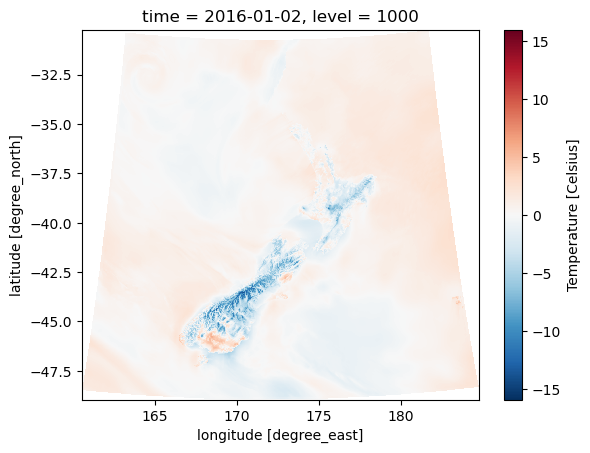

In [15]:
# calculate diffs for target variable in NZRA dataset
# ERA5 and NZRA are on different grids

for var in target_variable:
    var_diff = f"{var}_diff"

    # compute the difference between ERA5 and NZRA for this variable
    if var in era5_ds.data_vars:
        era5_interp = era5_ds[var].interp(lat=nzra_ds.lat, lon=nzra_ds.lon, method="linear")

        nzra_ds[f"{var}_diff"] = nzra_ds[var] - era5_interp
        logger.info(f"Computed difference between NZRA and ERA5 for variable {var}.")
    else:
        logger.warning(f"Variable {var} not found in ERA5 dataset. Cannot compute difference.")

    if dev:
        nzra_ds.isel(time=0)[var_diff].plot()
        plt.show()

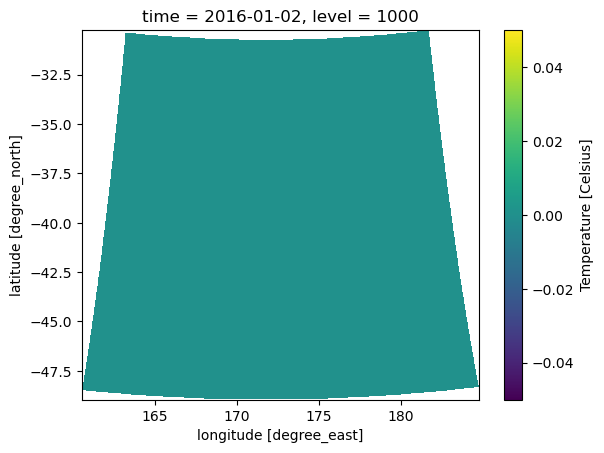

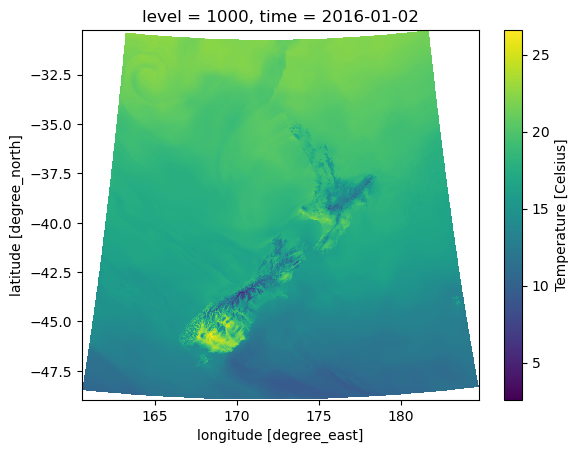

In [16]:
# check that NZRA can be recreated from ERA5 + diff
if dev:
    for var in target_variable:
        var_diff = f"{var}_diff"

        era5_interp = era5_ds[var].interp(lat=nzra_ds.lat, lon=nzra_ds.lon, method="linear")

        nzra_recreated = era5_interp + nzra_ds[var_diff]

        diff = nzra_ds[var] - nzra_recreated

        diff.isel(time=0).plot()
        plt.show()

        nzra_recreated.isel(time=0).plot()
        plt.show()

#### Pre-process Auxilliary Data (topography)

In [17]:
# preprocess auxiliary dataset (topography, tpi, land/sea mask)
ds_aux = topography_processor.compute_tpi(topography_ds, window_sizes=[0.1])
ds_aux = ds_aux.reindex({LATITUDE: nzra_ds[LATITUDE], LONGITUDE: nzra_ds[LONGITUDE]}, method='nearest') # expand to the NZRA grid

ds_aux[LAND_SEA_MASK] = ds_aux[ELEVATION].where(ds_aux[ELEVATION].isnull(), 1, 0).fillna(0)

ds_aux_coarse  = ds_aux.coarsen(
    lat=TOPO_COARSEN, 
    lon=TOPO_COARSEN, 
    boundary='trim').mean()

ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

logger.info("Auxiliary Preprocessing complete.")

2026-02-12 00:59:15 - INFO - __main__ - Auxiliary Preprocessing complete.


#### Crop datasets to matching square bounds

In [198]:
# crop all datasets to a square bound of lat -32.5, -47.5 and lon 165, 180
crop_bottom = -47.5
crop_top = -32.5
crop_left = 165.0
crop_right = 180.0

nzra_ds = nzra_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
era5_ds = era5_ds.sel(lat=slice(crop_top, crop_bottom), lon=slice(crop_left, crop_right))
ds_aux = ds_aux.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
ds_aux_coarse = ds_aux_coarse.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))

stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]

if load_himawari:
    h8_ds = h8_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))

logger.info("Datasets cropped to NZ region.")

2026-02-10 23:31:58 - INFO - __main__ - Datasets cropped to NZ region.


In [199]:
logger.info("Dataset preprocessing completed.")
if not dev:
    tb_writer.add_text(TB_RUN_LOGS, "Dataset preprocessing completed.", 1)
    tb_writer.flush()

2026-02-10 23:31:58 - INFO - __main__ - Dataset preprocessing completed.


## Visualise data sources

This may be removed eventually...

#### Himawari 8

Visualise the himawari8 dataset in bands 3, 9, and 13. Each band provides different information about clouds in the atmosphere.

This will be assimilated into the ERA5 data

In [200]:
if load_himawari:
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    h8_ds.isel(time=1)[BAND_3].plot(ax=ax[0])
    h8_ds.isel(time=1)[BAND_9].plot(ax=ax[1])
    h8_ds.isel(time=1)[BAND_13].plot(ax=ax[2])

    plt.tight_layout()

#### NZRA
Visualise temperature from the NZRA dataset.

This will be sampled from and used as the target set.

For initial experiments, the target is 'temperature' but will be updated as use-cases require.

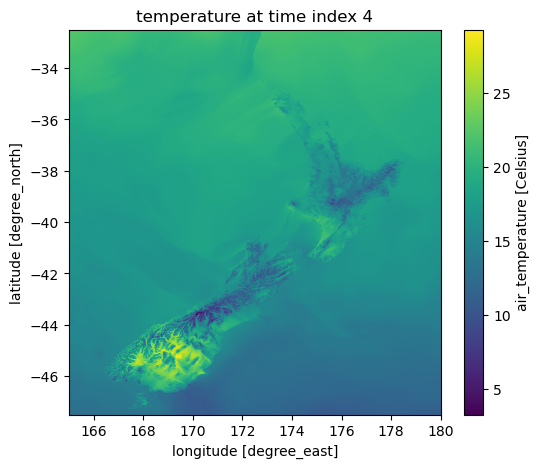

In [201]:
if dev:
    for var in target_variable:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        nzra_ds[var].isel(time=4).plot(ax=ax)
        plt.title(f"{var} at time index 4")
        plt.show()

#### Auxiliary
Elevation, TPI, and land/sea mask.

This is auxiliary - i.e. constant across time.

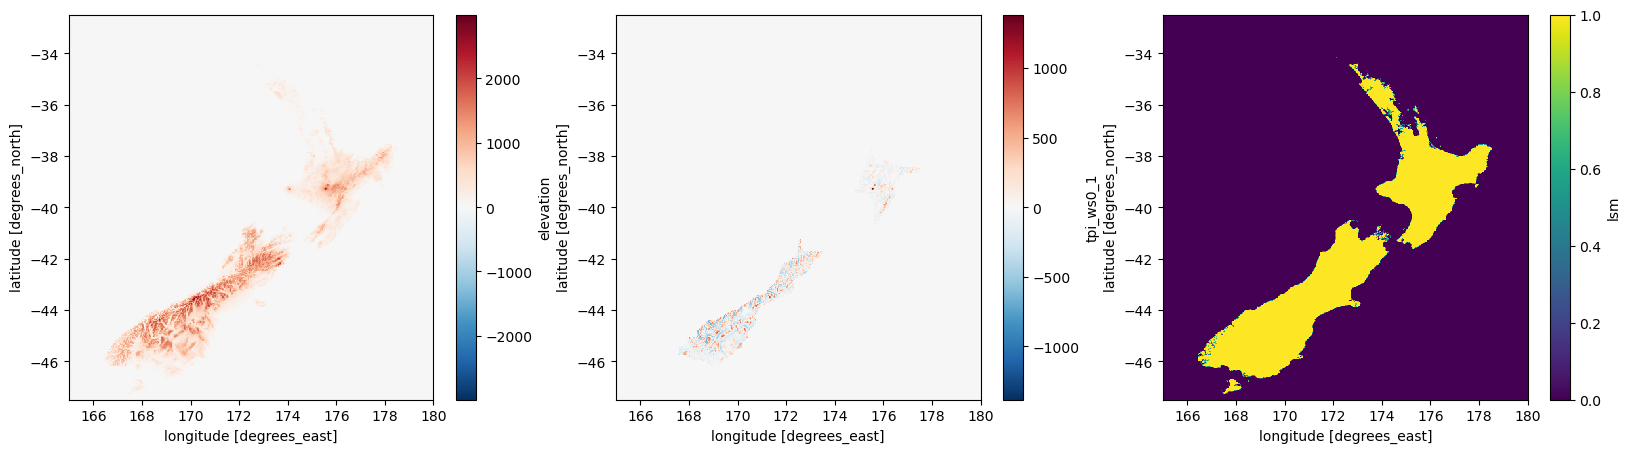

In [202]:
if dev:
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    ds_aux_coarse[ELEVATION].plot(ax=ax[0])
    ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_1"].plot(ax=ax[1])
    ds_aux_coarse[LAND_SEA_MASK].plot(ax=ax[2])

#### ERA5
The following six variables together form a closed description of the atmosphere. We may include all these variables in the model.

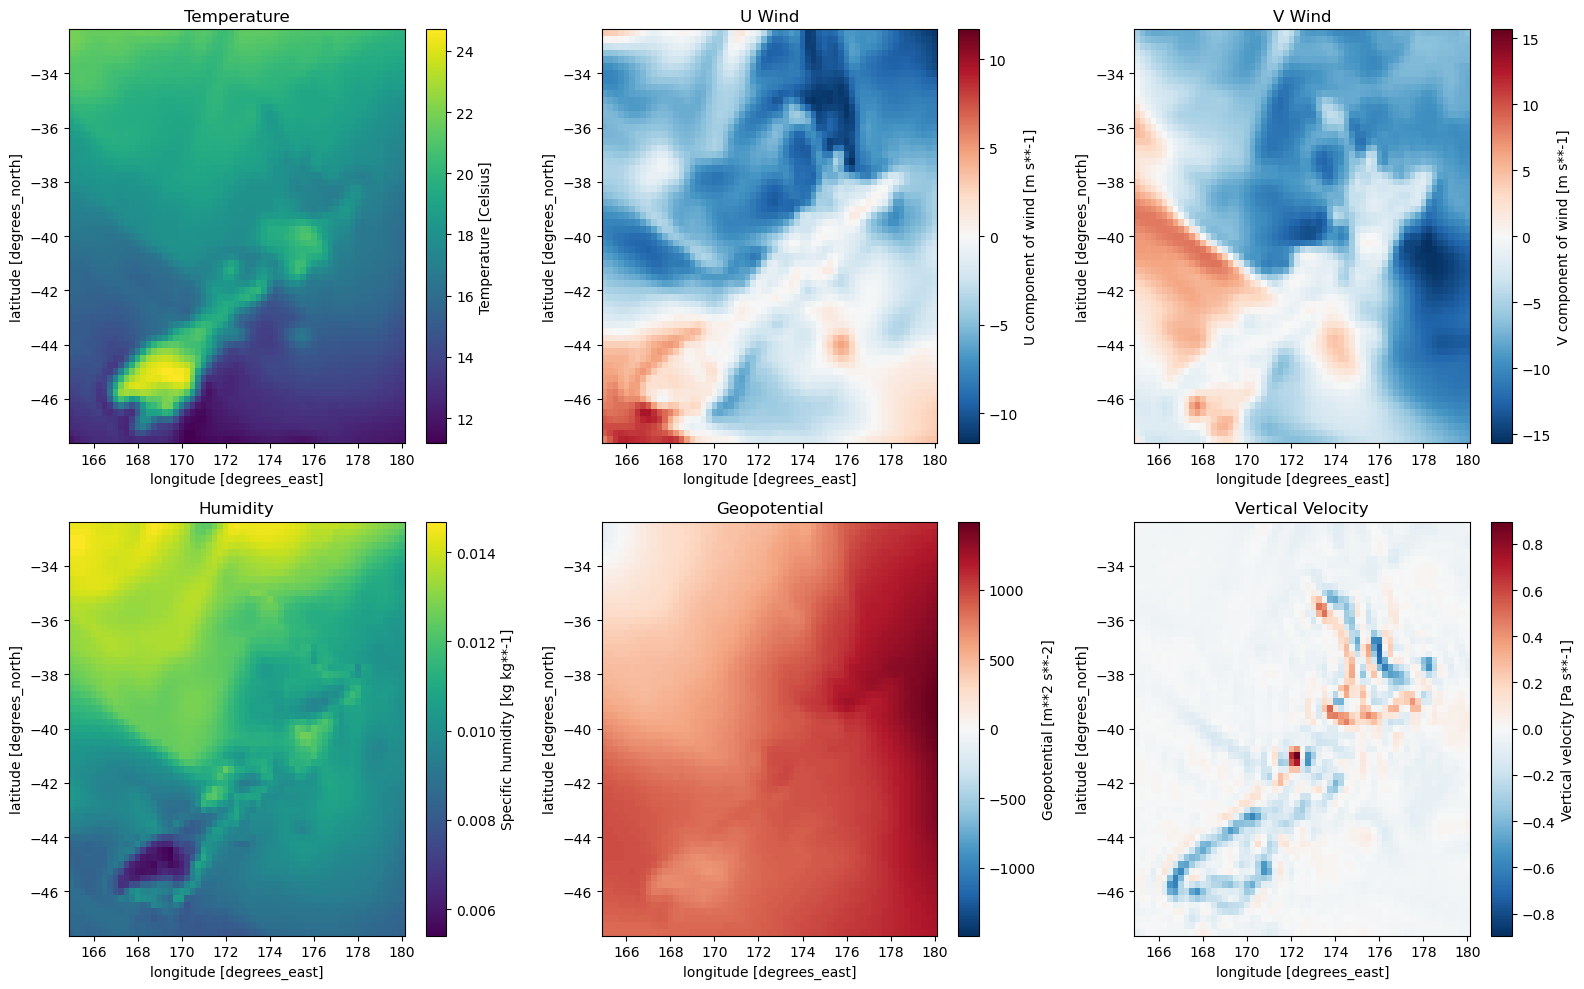

In [203]:
if dev:
    fig, ax = plt.subplots(2, 3, figsize=(16, 10))

    era5_ds[TEMPERATURE].isel(time=3).plot(ax=ax[0, 0])
    ax[0, 0].set_title("Temperature")

    era5_ds[WIND_U].isel(time=3).plot(ax=ax[0, 1])
    ax[0, 1].set_title("U Wind")

    era5_ds[WIND_V].isel(time=3).plot(ax=ax[0, 2])
    ax[0, 2].set_title("V Wind")

    era5_ds[HUMIDITY].isel(time=3).plot(ax=ax[1, 0])
    ax[1, 0].set_title("Humidity")

    era5_ds[GEOPOTENTIAL].isel(time=3).plot(ax=ax[1, 1])
    ax[1, 1].set_title("Geopotential")

    era5_ds[VERTICAL_VELOCITY].isel(time=3).plot(ax=ax[1, 2])
    ax[1, 2].set_title("Vertical Velocity")
    plt.tight_layout()

#### ERA5 Sun Position Annotations

The sun culmination and sun angle have been added as extra channels to ERA5 to encode time of year and time of day respectively.

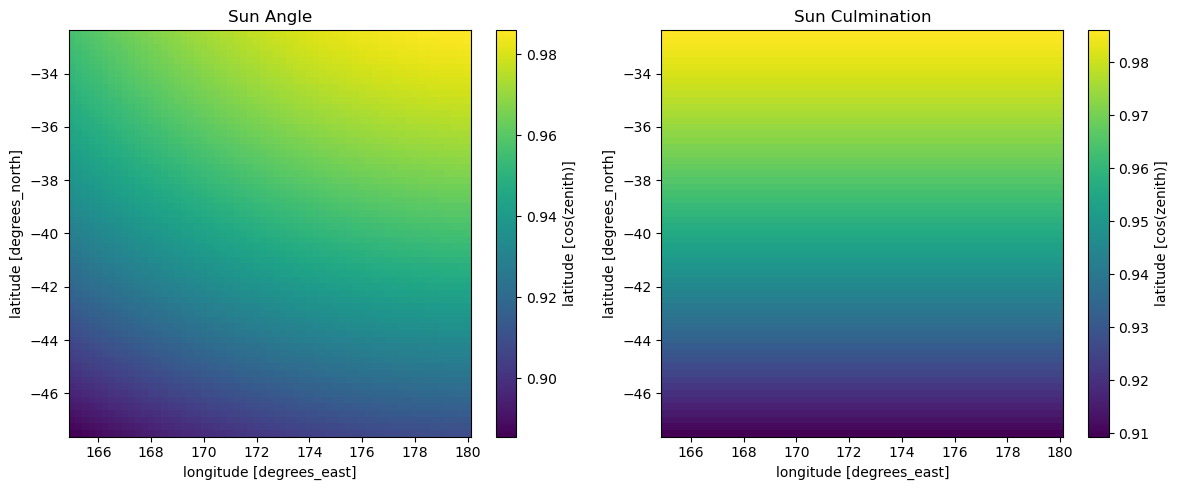

In [204]:
if dev:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    era5_ds[SUN_ANGLE].isel(time=0).plot(ax=ax[0])
    ax[0].set_title("Sun Angle")

    era5_ds[SUN_CULMINATION].isel(time=0).plot(ax=ax[1])
    ax[1].set_title("Sun Culmination")

    plt.tight_layout()

#### Ground Stations

A subset (and arbitrary number) of ground stations will be used as off-grid inputs to the model.

A set of stations can also be used as supplementary target points to NZRA - letting the model learn at spaces off the NZRA grid, and theoretically allowing the model to learn outputs which could be "more correct" than NZRA - provided the stations haven't been assimilated into NZRA.

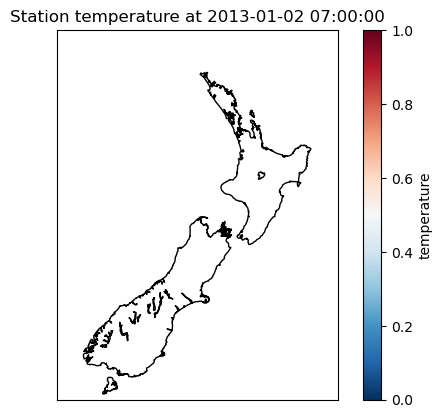

In [205]:
if dev:        
    for var in target_variable:
        time_step = "2013-01-02 07:00:00"
        m = Basemap(projection='merc', llcrnrlat=nzra_ds[LATITUDE].min().item(), urcrnrlat=nzra_ds[LATITUDE].max().item(), llcrnrlon=nzra_ds[LONGITUDE].min().item(), urcrnrlon=nzra_ds[LONGITUDE].max().item(), resolution='i')
        m.drawcoastlines()
        m.drawcountries()
        x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
                stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
        sc = m.scatter(x, y,
                        c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step][var].values,
                        cmap='RdBu_r', marker='o', edgecolor='k', s=100)
        plt.colorbar(sc, label=f'{var}')
        plt.title(f'Station {var} at {time_step}')
        plt.show()

## Final Filtering of datasets

This will vary by experiment.

In [24]:
# only select temperature + sun position from ERA5
era5_ds = era5_ds[[TEMPERATURE] + [SUN_ANGLE]]

# regrid ERA5 to NZRA grid using linear interpolation
era5_ds = era5_ds.chunk({"time": 1, "lat": 61, "lon": 61})
era5_ds = era5_ds.interp(lat=nzra_ds.lat, lon=nzra_ds.lon, method="linear")

# only select topography + lsm from auxiliary
ds_aux = ds_aux[[ELEVATION]]
ds_aux_coarse = ds_aux_coarse[[ELEVATION]]

# filter NZRA to only land points using the land-sea mask. Set sea points to NaN so they are ignored during training and evaluation
nzra_ds = nzra_ds.where(nzra_ds[LAND_SEA_MASK] == 1)

# select the diffs from NZRA as targets
nzra_ds = nzra_ds[target_variable_diff]

## Deepsensor Dataset Generation

The data needs to be converted from xarray datasets/csv's into deepsensor tasks.

To reiterate the dataset structure:
This varies by experiment so is indicative only

#### Context Sets
1. Gridded context: ERA5, Himawari 8, sun position.
2. Offgrid context: Ground station observations.
3. Auxiliary: Topography, x1x2 encoding, land/sea mask.

#### Target Sets:
1. Points from NZRA, sampled at random locations.
2. (tbc) held-out station observations. *note*: we are thinking of adding in some station observations amongst the NZRA data, as it might further increase real-world accuracy. But we would need to discuss the advantages/disadvantages of doing this first. It would be harder to measure model accuracy, as we aren't comparing 'fit to NZRA' anymore.

In [25]:
# create dataset/model directories

dataset_pickle_path = get_env_var('DATASET_PICKLE_PATH')
models_path = get_env_var('MODEL_DIR')

train_suffix = 'experiment5_nzra_target_train_tasks'
val_suffix = 'experiment5_nzra_target_val_tasks'

train_dir = os.path.join(dataset_pickle_path, train_suffix)
val_dir = os.path.join(dataset_pickle_path, val_suffix)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# create model directories
model_dir = os.path.join(models_path, EXPERIMENT_NAME)
checkpoint_dir = os.path.join(model_dir, 'checkpoints')
norm_dir = os.path.join(model_dir, 'norm_params')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(norm_dir, exist_ok=True)

A model is required to generate tasks. A model needs a task loader, and a task loader needs processed dataframes. The first time this notebook runs, a data_processor is saved to `norm_dir`. In future runs, the notebook attempts to load a saved data processor from the `norm_dir`, to avoid data leakage. The initial data_processor is created with a sample of 1000 tasks.

In [26]:
save_data_processor = True

try:
    data_processor = DataProcessor(norm_dir)
    logger.info(f"Loaded existing normalization parameters: {data_processor}")
    save_data_processor = False # this stops the data processor from being saved again later
except:
    data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds[LATITUDE].min(), era5_ds[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds[LONGITUDE].min(), era5_ds[LONGITUDE].max()))
    logger.info("Created new Deepsensor DataProcessor and will compute normalization parameters.")

/esi/project/niwa00004/crowelenn/dev/deepsensor/deepsensor/data/processor.py:128: UserWarning: x1_map and x2_map have different ranges.This can lead to stretching/squashing of data, which may impact model performance.
  warnings.warn(
2026-02-10 22:23:29 - INFO - __main__ - Created new Deepsensor DataProcessor and will compute normalization parameters.


Processing all the datasets at once (before task generation) leads to an OOM error, and a subsequent kernel crash. Instead, we are going to fit the data_processor to a subset of the training data (to estimate normalisation parameters) and then generate the processed sets for dates individually at task generation time.

In [27]:
%autoreload 2
from convcnp_assim_nz.data_processing.normalize.coordinate_normalizer import CoordinateNormalizer

In [28]:
# filter the stations to be within the bounds of the ERA5 grid
stations_df = stations_df[(stations_df[LATITUDE] >= era5_ds[LATITUDE].min().item()) & (stations_df[LATITUDE] <= era5_ds[LATITUDE].max().item()) &
                          (stations_df[LONGITUDE] >= era5_ds[LONGITUDE].min().item()) & (stations_df[LONGITUDE] <= era5_ds[LONGITUDE].max().item())]

In [29]:
# build the residual station error

stations_df['nearest_lat'] = (stations_df['lat']*4).round()/4
stations_df['nearest_lon'] = (stations_df['lon']*4).round()/4

# filter era5_ds to only the nearest lat/lon points to the stations, to speed up the join operation when building the residual station error
era5_ds_filtered = era5_ds.sel(lat=stations_df['nearest_lat'].unique(), lon=stations_df['nearest_lon'].unique(), method="nearest")

temp_df = era5_ds_filtered[TEMPERATURE].to_dataframe()

temp_df['lat_round'] = (temp_df.index.get_level_values('lat')*4).round()/4
temp_df['lon_round'] = (temp_df.index.get_level_values('lon')*4).round()/4

In [30]:
# join stations with ERA5 data
stations_reset = stations_df.reset_index()
stations_era5 = stations_reset.merge(temp_df.reset_index(), how='left', left_on=['time', 'nearest_lat', 'nearest_lon'], right_on=['time', 'lat_round', 'lon_round'], suffixes=('', '_era5'))

In [31]:
stations_era5['residual'] = stations_era5[TEMPERATURE] - stations_era5[f"{TEMPERATURE}_era5"]

In [32]:
era5_ds_with_target = era5_ds.copy()

# drop era5 temperature now, as it won't be used in the model
era5_ds = era5_ds.drop_vars(TEMPERATURE)

In [225]:
stations_era5.head()

,index,temperature,lat,lon,time,nearest_lat,nearest_lon,lat_era5,lon_era5,level,temperature_era5,lat_round,lon_round,residual
0,5117868,20.75,-40.61986,175.25954,2016-01-02,-40.50,175.25,-40.4990,175.2435,1000,19.381240,-40.50,175.25,1.368760
1,5117869,19.20,-40.90455,174.98517,2016-01-02,-41.00,175.00,-40.9985,175.0005,1000,19.066676,-41.00,175.00,0.133324
2,5117870,15.10,-38.28566,177.52941,2016-01-02,-38.25,177.50,-38.2445,177.4980,1000,17.318832,-38.25,177.50,-2.218832
3,5117871,17.75,-41.27058,172.15568,2016-01-02,-41.25,172.25,-41.2550,172.2465,1000,18.785687,-41.25,172.25,-1.035687
4,5117872,8.85,-42.01777,172.64677,2016-01-02,-42.00,172.75,-41.9975,172.7460,1000,18.809751,-42.00,172.75,-9.959751


In [33]:
custom_norm_dir = os.path.join(norm_dir, "custom_norm")
print(custom_norm_dir)

/esi/project/niwa00004/crowelenn/data/model/exp5_nzra_diff_coord_norm_landonly/default_experiment/norm_params/custom_norm


In [34]:
normalizer = CoordinateNormalizer()

if normalizer.try_load(custom_norm_dir): # try_load will attempt to load the normalization parameters, and return True if successful, False if not
    normalizer.load(custom_norm_dir)
    logger.info("Loaded existing normalization parameters for custom normalizer.")

stations_norm, nzra_norm = normalizer([stations_era5[['residual', TIME, LATITUDE, LONGITUDE]], nzra_ds[[f"{TEMPERATURE}_diff"]]])

normalizer.save_if_not_loaded(custom_norm_dir)

Could not load normalization parameters from /esi/project/niwa00004/crowelenn/data/model/exp5_nzra_diff_coord_norm_landonly/default_experiment/norm_params/custom_norm. Error: [Errno 2] No such file or directory: '/esi/project/niwa00004/crowelenn/data/model/exp5_nzra_diff_coord_norm_landonly/default_experiment/norm_params/custom_norm'


/esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/.pixi/envs/default/lib/python3.13/site-packages/dask/array/numpy_compat.py:61: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Normalization parameters saved to /esi/project/niwa00004/crowelenn/data/model/exp5_nzra_diff_coord_norm_landonly/default_experiment/norm_params/custom_norm


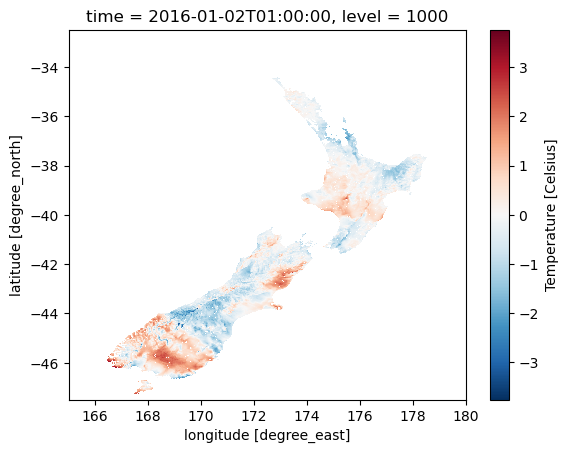

In [35]:
nzra_norm.isel(time=1)[f"{TEMPERATURE}_diff_norm"].plot()

(array([10.,  4., 12.,  5., 25., 39., 59., 64., 76., 80., 85., 60., 47.,
        29., 12.,  5.,  3.,  3.,  2.,  4.]),
 array([-2.83799063, -2.52606875, -2.21414687, -1.90222499, -1.5903031 ,
        -1.27838122, -0.96645934, -0.65453746, -0.34261558, -0.0306937 ,
         0.28122819,  0.59315007,  0.90507195,  1.21699383,  1.52891571,
         1.8408376 ,  2.15275948,  2.46468136,  2.77660324,  3.08852512,
         3.400447  ]),
 <BarContainer object of 20 artists>)

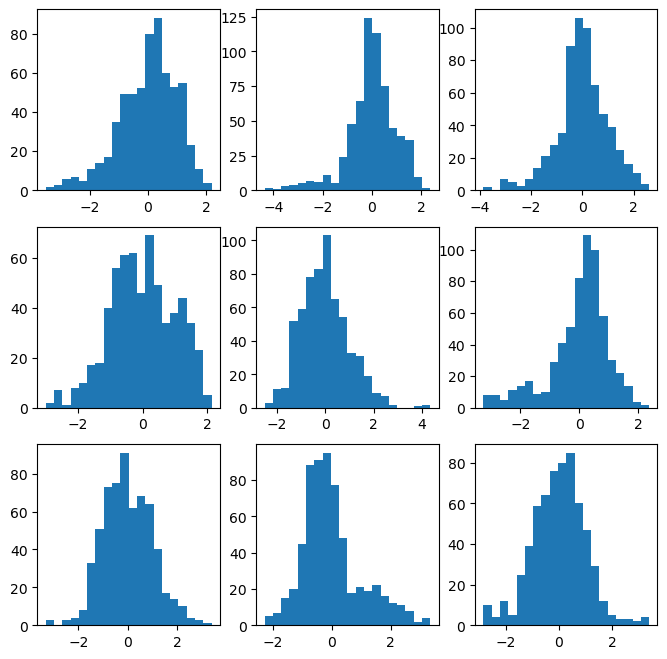

In [36]:
# check that the normalized diffs have mean ~0 and std ~1 for a few stations by plotting some histograms


fig, ax = plt.subplots(3, 3, figsize=(8,8))
ax[0,0].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -40.61986) & (stations_norm.index.get_level_values('lon') == 175.25954)]["residual_norm"], bins=20)
ax[0,1].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -40.90455) & (stations_norm.index.get_level_values('lon') == 174.98517)]["residual_norm"], bins=20)
ax[0,2].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -38.28566) & (stations_norm.index.get_level_values('lon') == 177.52941)]["residual_norm"], bins=20)
ax[1,0].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -41.27058) & (stations_norm.index.get_level_values('lon') == 172.15568)]["residual_norm"], bins=20)
ax[1,1].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -42.01777) & (stations_norm.index.get_level_values('lon') == 172.64677)]["residual_norm"], bins=20)
ax[1,2].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -45.90129) & (stations_norm.index.get_level_values('lon') == 170.51470)]["residual_norm"], bins=20)
ax[2,0].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -45.22172) & (stations_norm.index.get_level_values('lon') == 167.62988)]["residual_norm"], bins=20)
ax[2,1].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -43.13409) & (stations_norm.index.get_level_values('lon') == 170.91264)]["residual_norm"], bins=20)
ax[2,2].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -44.83407) & (stations_norm.index.get_level_values('lon') == 167.77752)]["residual_norm"], bins=20)


In [37]:
# determine the training and validation date ranges

date_vals = np.unique(stations_resample.index.get_level_values('time').values)

train_pct = int(len(date_vals) * TRAIN_SPLIT)
valid_pct = len(date_vals) - train_pct

train_datetimes = date_vals[:train_pct]
val_datetimes   = date_vals[train_pct:]

# use all training datetimes for norm parameter estimation
norm_datetimes = np.array(train_datetimes)

In [38]:
# datasets not requiring per-location normalisation are passed through the deepsensor data processor
era5_processed_ds = data_processor(era5_ds)
ds_aux_processed, ds_aux_coarse_processed = data_processor([ds_aux, ds_aux_coarse], method='min_max')

x1x2_ds = construct_x1x2_ds(ds_aux_coarse_processed)
ds_aux_coarse_processed['x1_arr'] = x1x2_ds['x1_arr']
ds_aux_coarse_processed['x2_arr'] = x1x2_ds['x2_arr']

nzra_deepsensor = data_processor.map_coords(nzra_norm)
stations_deepsensor = data_processor.map_coords(stations_norm)

In [39]:
# himawari8 has been temporarily excluded

norm_task_loader = TaskLoader(
            context = [stations_deepsensor, era5_processed_ds, ds_aux_coarse_processed], 
            target = nzra_deepsensor,
            aux_at_targets = ds_aux_processed)

In [40]:
model = ConvNP(data_processor, 
               norm_task_loader, 
               unet_channels=UNET_CHANNELS, 
               likelihood="gnp", 
               internal_density=INTERNAL_DENSITY,
               conv_arch="unet-res",
               aux_t_mlp_layers=(128, 256, 128),
               unet_kernels=7)

dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 1
encoder_scales inferred from TaskLoader: [0.0009009009009009009, 0.00045045046135783195, 0.0009009009227156639]
decoder_scale inferred from TaskLoader: 0.0018018018018018018


In [41]:
from convcnp_assim_nz.learning.model_diagnostics import count_model_parameters
print(count_model_parameters(model.model))

Total number of parameters: 1079574
1079574


In [42]:
print(f"ERA5 Resolution: {1/compute_xarray_data_resolution(era5_processed_ds)}")
#print(f"H8 Resolution: {1/compute_xarray_data_resolution(h8_processed_estimator_ds)}")
print(f"NZRA Resolution: {1/compute_xarray_data_resolution(nzra_deepsensor)}")
print(f"Auxiliary Resolution: {1/compute_xarray_data_resolution(ds_aux_processed)}")
print(f"Stations Resolution: {1/compute_pandas_data_resolution(stations_deepsensor)}")

ERA5 Resolution: 1110.0
NZRA Resolution: 1110.0
Auxiliary Resolution: 1110.0
Stations Resolution: 1217.971909643898


Hence using 1111 for the model internal density.

In [43]:
#import cartopy
#import cartopy.crs as ccrs
#import cartopy.feature as cf

#cartopy.config['data_dir'] = get_env_var("CARTOPY_FILES_DIR")

#fig = deepsensor.plot.receptive_field(model.model.receptive_field, data_processor, ccrs.PlateCarree(), (165, 180, -47.5, -32.5))

In [44]:
logger.info("Training and validation datetime splits created. Setting up dataset pickle file paths.")

2026-02-10 22:24:36 - INFO - __main__ - Training and validation datetime splits created. Setting up dataset pickle file paths.


In [45]:
if (not dev) and save_data_processor:
    data_processor.save(norm_dir)

In [46]:
def generate_and_save_tasks(
    datetimes,
    era5_ds,
    nzra_ds,
    stations_resample,
    data_processor,
    task_dir,
    ds_aux_coarse_processed,
    ds_aux_processed,
    logger,
    tasks_len,
    split_name,
    *,
    h8_ds=None,
    load_himawari=False,
    process_year=None,
    all_years=None,
):
    # Generate Deepsensor tasks for a given split and save them to disk.

    logger.info(f"Generating {split_name} Deepsensor tasks.")

    for i, date in enumerate(datetimes):
        # Select data for this timestep
        era5_date_ds = era5_ds.sel(time=date)
        nzra_date_ds = nzra_ds.sel(time=date)
        stations_date_df = stations_resample.loc[
            stations_resample.index.get_level_values("time") == date
        ]

        if load_himawari:
            _ = h8_ds.sel(time=date)  # kept for future use

        # Process data
        era5_proc = data_processor(
            era5_date_ds
        )

        # Build task loader
        task_loader = TaskLoader(
            context=[stations_date_df, era5_proc, ds_aux_coarse_processed],
            target=nzra_date_ds,
            aux_at_targets=ds_aux_processed,
        )

        # File path logic
        if process_year is not None:
            base_idx = all_years.index(process_year) * (366 - 2) * 24
            filename = f"{base_idx + i}_0.pkl"
        else:
            filename = f"{i}_0.pkl"

        path = os.path.join(task_dir, filename)

        # Create and save task
        task = task_loader(
            date,
            context_sampling=["all", "all", "all"],
            target_sampling=["all"],
        )

        with open(path, "wb") as f:
            pickle.dump(task, f)

        if i % 10 == 0:
            logger.info(
                f"dataset generation progress: {i}/{tasks_len} {split_name} tasks completed."
            )

    logger.info(f"{split_name.capitalize()} Deepsensor task dataset generation completed.")

In [47]:
# compute lengths for logging
train_tasks_len = len(train_datetimes)
val_tasks_len = len(val_datetimes)

logger.info(f"Train dataset: {len(train_datetimes)}.")
logger.info(f"Validation dataset: {len(val_datetimes)}.")
logger.info("Dataset generation beginning.")

# you can disable dataset generation by setting the DATASET_GENERATION env var to "0"
if dataset_generation:
    logger.info("Generating and saving Deepsensor tasks to disk.")

    # generate train tasks
    generate_and_save_tasks(
        datetimes=train_datetimes,
        era5_ds=era5_ds,
        nzra_ds=nzra_deepsensor,
        stations_resample=stations_deepsensor,
        data_processor=data_processor,
        task_dir=train_dir,
        ds_aux_coarse_processed=ds_aux_coarse_processed,
        ds_aux_processed=ds_aux_processed,
        logger=logger,
        tasks_len=train_tasks_len,
        split_name="train",
        load_himawari=load_himawari,
        process_year=process_year,
        all_years=all_years,
    )

    # generate validation tasks
    generate_and_save_tasks(
        datetimes=val_datetimes,
        era5_ds=era5_ds,
        nzra_ds=nzra_deepsensor,
        stations_resample=stations_deepsensor,
        data_processor=data_processor,
        task_dir=val_dir,
        ds_aux_coarse_processed=ds_aux_coarse_processed,
        ds_aux_processed=ds_aux_processed,
        logger=logger,
        tasks_len=val_tasks_len,
        split_name="val",
        process_year=process_year,
        all_years=all_years,
    )

    logger.info("Deepsensor task dataset generation completed.")
    if not dev:
        tb_writer.add_text(
            TB_RUN_LOGS,
            "Deepsensor task dataset generation completed.",
            2,
        )
else:
    if not dev:
        tb_writer.add_text(TB_RUN_LOGS, "Deepsensor task dataset generation skipped.", 2)

2026-02-10 22:24:36 - INFO - __main__ - Train dataset: 436.
2026-02-10 22:24:36 - INFO - __main__ - Validation dataset: 188.
2026-02-10 22:24:36 - INFO - __main__ - Dataset generation beginning.


In [48]:
task_to_plot = norm_task_loader(norm_datetimes[0], context_sampling=["all", "all", "all"], target_sampling=["all"])

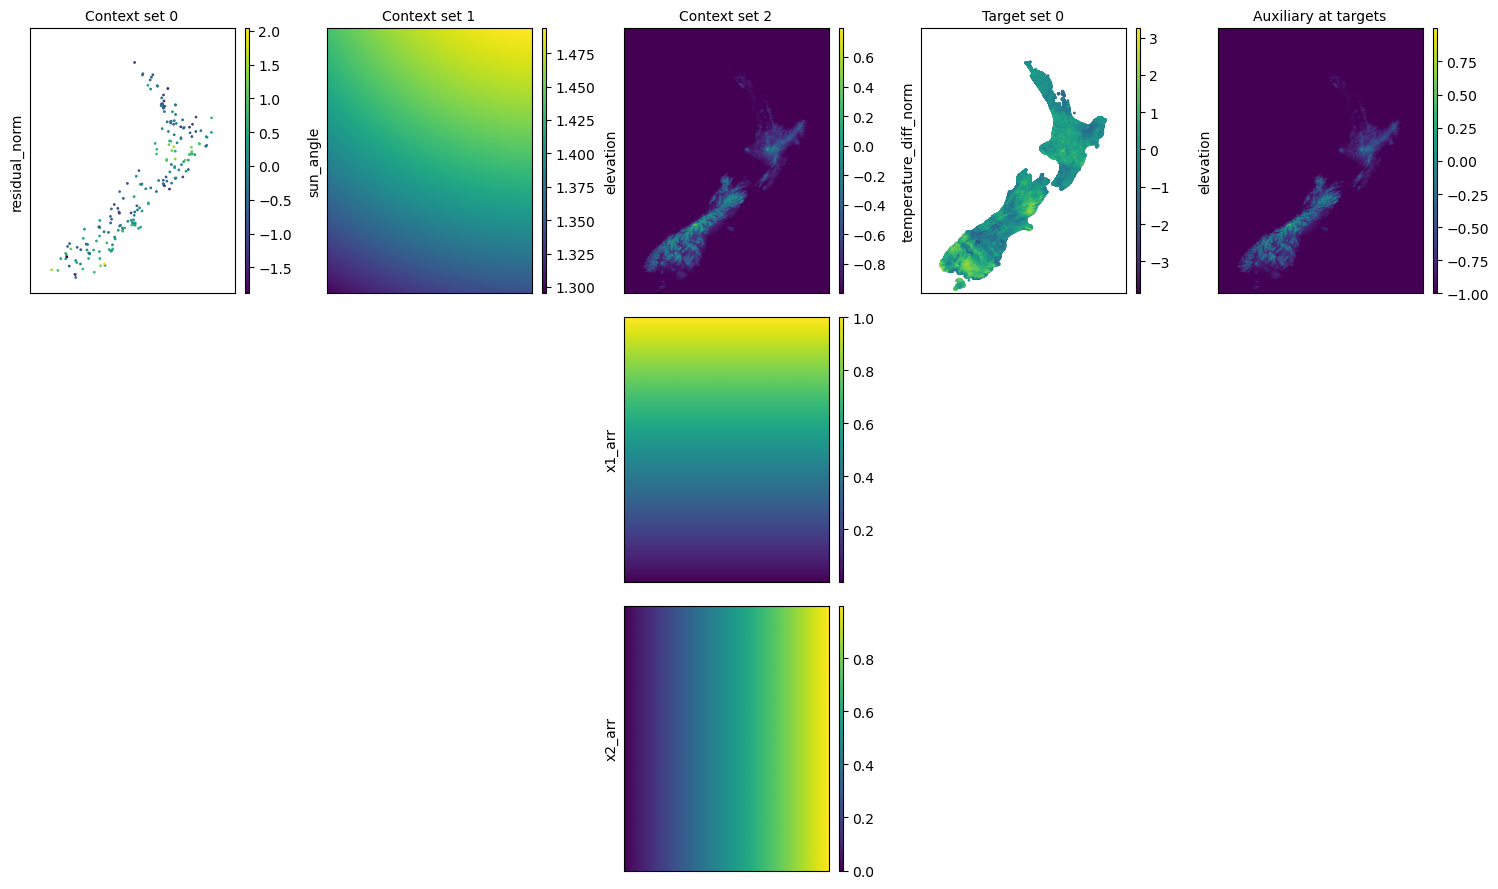

In [49]:
plot_task = deepsensor.plot.task(task_to_plot, norm_task_loader)
plot_task.show()

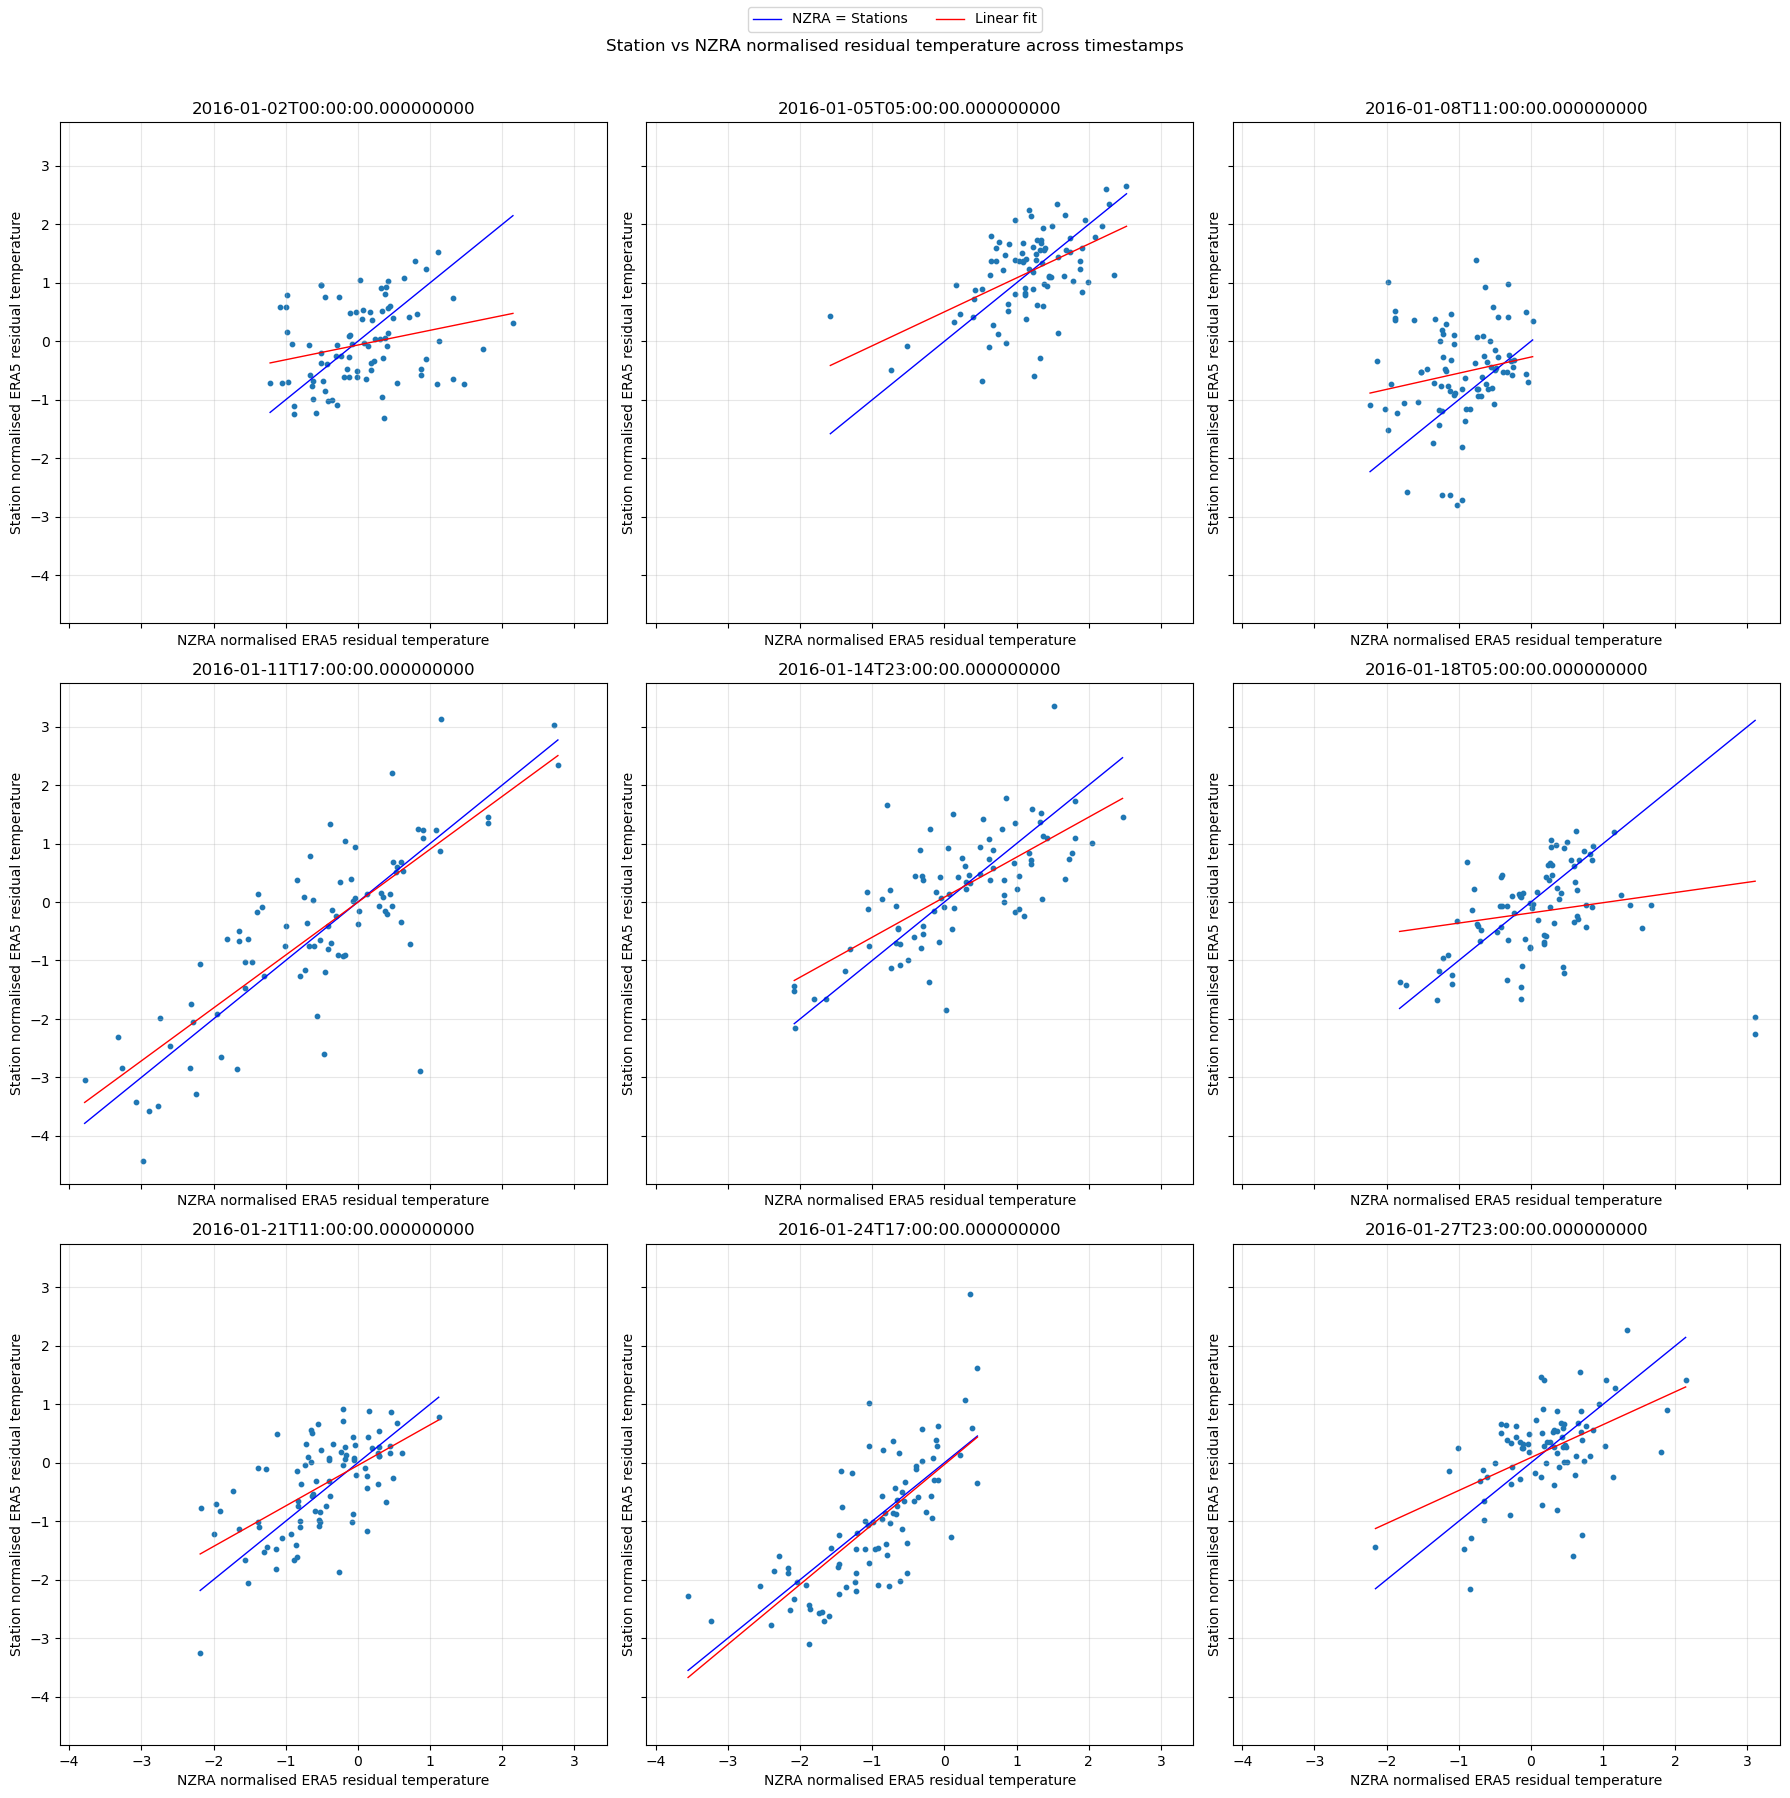

In [251]:
timestamps = nzra_norm[TIME].values
if len(timestamps) < 9:
    raise ValueError("Need at least nine NZRA timestamps to build the validation grid plot.")
timestamp_idx = np.linspace(0, len(timestamps) - 1, 9, dtype=int)
timestamps_to_plot = timestamps[timestamp_idx]
lat0 = -47.492
lon0 = 165.0105
dx = 0.0135
stations_reindex = stations_norm.reset_index()
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)
for ax, timestamp_temp_validation in zip(axes.ravel(), timestamps_to_plot):
    temp_diff_norm_df = (
        nzra_norm
        .sel(time=timestamp_temp_validation)[f"{TEMPERATURE}_diff_norm"]
        .to_dataframe(name="temperature_diff_norm")
        .reset_index()[["lat", "lon", "temperature_diff_norm"]]
    )
    stations_df_validate_temp = stations_reindex[
        stations_reindex["time"] == timestamp_temp_validation
    ].copy()
    if stations_df_validate_temp.empty or temp_diff_norm_df.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(str(timestamp_temp_validation))
        continue
    stations_df_validate_temp["nearest_lat_nzra"] = np.round(
        lat0 + np.round((stations_df_validate_temp["lat"] - lat0) / dx) * dx, 4
    )
    stations_df_validate_temp["nearest_lon_nzra"] = np.round(
        lon0 + np.round((stations_df_validate_temp["lon"] - lon0) / dx) * dx, 4
    )
    joined = stations_df_validate_temp.merge(
        temp_diff_norm_df,
        how="left",
        left_on=["nearest_lat_nzra", "nearest_lon_nzra"],
        right_on=["lat", "lon"],
    )
    joined_filtered = joined[joined["temperature_diff_norm"].notna()]
    if joined_filtered.empty:
        ax.text(0.5, 0.5, "No overlap", ha="center", va="center")
        ax.set_title(str(timestamp_temp_validation))
        continue
    line = np.linspace(
        joined_filtered["temperature_diff_norm"].min(),
        joined_filtered["temperature_diff_norm"].max(),
        100,
    )
    fit = np.polyfit(
        joined_filtered["temperature_diff_norm"], joined_filtered["residual_norm"], 1
    )
    p = np.poly1d(fit)
    ax.scatter(
        joined_filtered["temperature_diff_norm"], joined_filtered["residual_norm"], s=10
    )
    ax.plot(line, line, label="NZRA = Stations", c="blue", linewidth=1)
    ax.plot(line, p(line), label="Linear fit", c="red", linewidth=1)
    ax.set_xlabel("NZRA normalised ERA5 residual temperature")
    ax.set_ylabel("Station normalised ERA5 residual temperature")
    ax.set_title(str(timestamp_temp_validation))
    ax.grid(True, alpha=0.3)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)
fig.suptitle("Station vs NZRA normalised residual temperature across timestamps")
plt.tight_layout(rect=(0, 0, 1, 0.97))

In [49]:
# save demo task to tensorboard
if not dev:
    tb_writer.add_figure(TB_EXAMPLE_TASK, plot_task.figure)
    tb_writer.flush()

/esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/src/convcnp_assim_nz/data_processing/normalize/coordinate_normalizer.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  """


mean
<xarray.DataArray 'temperature_diff' (lat: 1111, lon: 1111)> Size: 5MB
array([[0.2775073 , 0.276544  , 0.27532253, ..., 0.33291283, 0.33685255,
        0.33912322],
       [0.2773961 , 0.27602327, 0.27436838, ..., 0.33551225, 0.3390968 ,
        0.34124053],
       [0.2767067 , 0.27522215, 0.2735433 , ..., 0.33645138, 0.339722  ,
        0.3420604 ],
       ...,
       [1.4152665 , 1.4160063 , 1.4166963 , ..., 1.1551497 , 1.155962  ,
        1.157473  ],
       [1.4173902 , 1.4179739 , 1.4179723 , ..., 1.1594864 , 1.1599363 ,
        1.1607797 ],
       [1.4192553 , 1.4198165 , 1.4201355 , ..., 1.1628373 , 1.1635174 ,
        1.1642597 ]], shape=(1111, 1111), dtype=float32)
Coordinates:
  * lat      (lat) float64 9kB -47.49 -47.48 -47.47 ... -32.53 -32.52 -32.51
  * lon      (lon) float64 9kB 165.0 165.0 165.0 165.1 ... 180.0 180.0 180.0
    level    int64 8B 1000
Attributes:
    standard_name:  air_temperature
    stash_item:     236
    stash_model:    1
    stash_section:  3
  

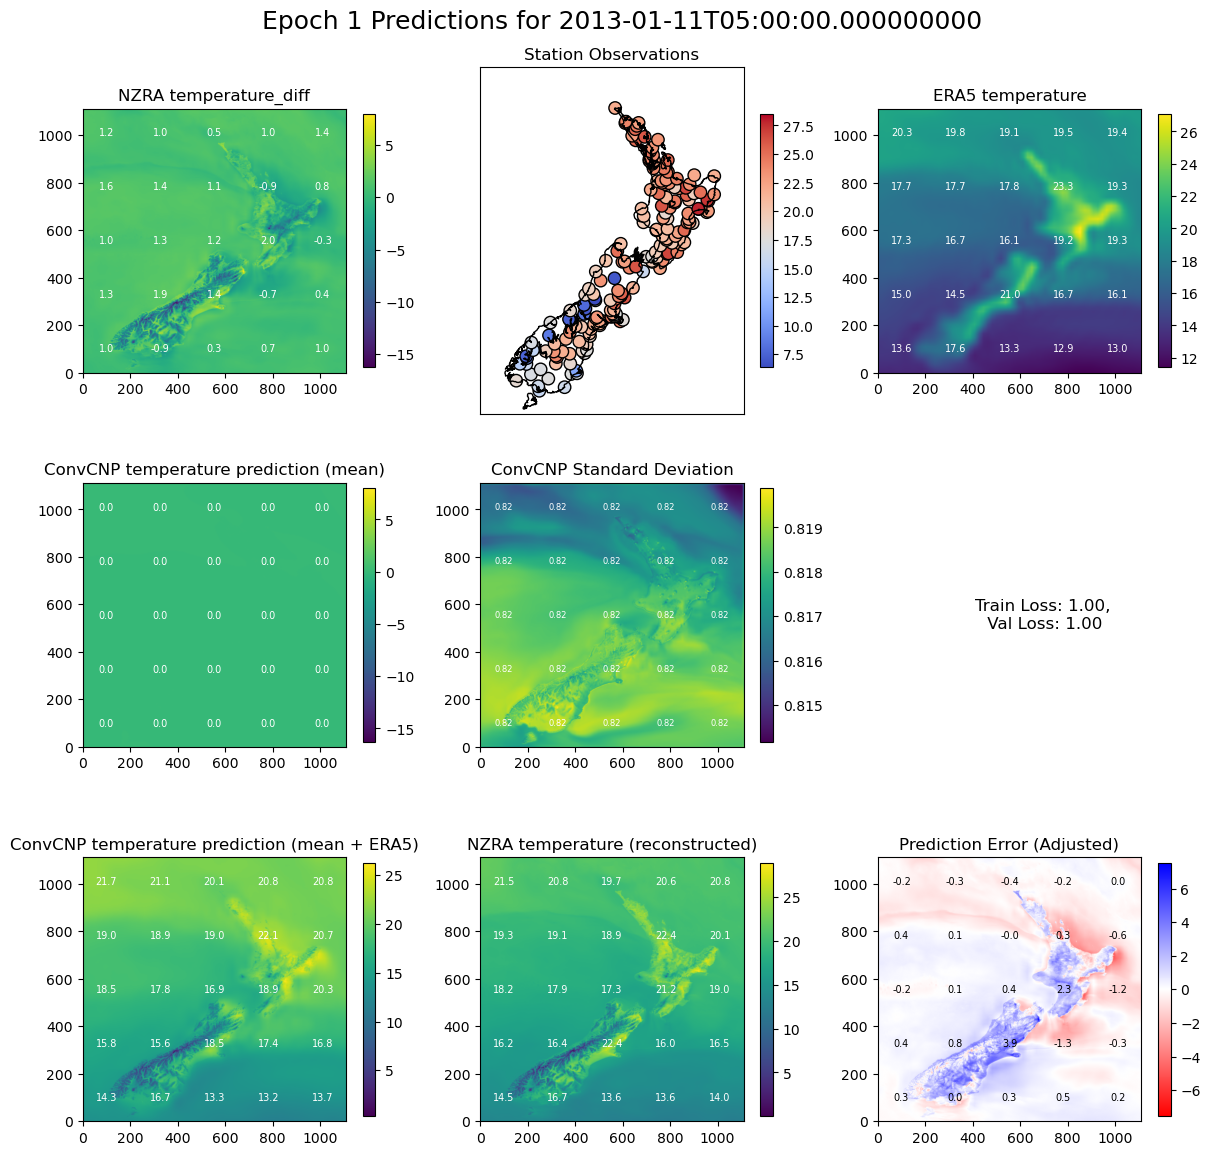

In [ ]:
"""train_date = train_datetimes[np.random.randint(0, len(train_datetimes))]
val_date = val_datetimes[np.random.randint(0, len(val_datetimes))]

# tasks are created on-the-fly here for prediction
era5_train_date_ds = era5_ds.sel(time=train_date)
era5_target_field = era5_ds_with_target.sel(time=train_date)[TEMPERATURE]
nzra_train_date_ds = nzra_ds.sel(time=train_date)
stations_train_date_df = stations_resample.loc[stations_resample.index.get_level_values('time') == train_date]

era5_val_date_ds = era5_ds_with_target.sel(time=val_date)
nzra_val_date_ds = nzra_ds.sel(time=val_date)
stations_val_date_df = stations_resample.loc[stations_resample.index.get_level_values('time') == val_date]

train_fig = return_sample_predictions(era5_train_date_ds, 
                                      era5_target_field,
                                      None, 
                                      nzra_train_date_ds, 
                                      nzra_ds, 
                                      stations_train_date_df, 
                                      ds_aux_processed, 
                                      ds_aux_coarse_processed, 
                                      train_date, 
                                      data_processor, 
                                      0+1, 
                                      model, 
                                      mode="diff", 
                                      target=var, 
                                      custom_norm=normalizer,
                                      subtitle_text=f"Train Loss: {1.00:.2f},\n Val Loss: {1.00:.2f}")

train_fig.show()"""

## Model Training

In [99]:
if not dev:
    tb_writer.add_hparams(
        {
            'initial_learning_rate': LR,
            'batch_size': BATCH_SIZE,
            'target_sampling_count': TARGET_SAMPLING_COUNT,
            'sampling_strategy': "all" if SAMPLING_STRATEGY == "all" else "repeated",
            'dev_mode': dev,
            'epochs': N_EPOCHS,
            'n_samples': len(train_datetimes),
            'unet': str(UNET_CHANNELS),
            'grad_clip': USE_GRAD_CLIP,
            'grad_clip_value': GRAD_CLIP_VALUE,
            'model_internal_density': INTERNAL_DENSITY,
            'model_receptive_field': model.model.receptive_field,
        },
        {}
    )

    tb_writer.add_text(TB_RUN_LOGS, f"Training started for {N_EPOCHS} epochs.", 3)
    tb_writer.flush()

In [ ]:
if dataset_generation and not dev:
    logger.info("Exiting before model training.")
    tb_writer.add_text(TB_RUN_LOGS, "Exiting before model training.", 4)
    tb_writer.flush()
    
    os._exit(0)

logger.info("Model training starting.")

2026-02-09 01:21:53 - INFO - __main__ - Model training starting.


: 

In [101]:
# save the initial untrained model
if not dev:
    model_save_path = os.path.join(model_dir, "initial_model")
    torch.save(model.model.state_dict(), model_save_path + ".pt")

# training loop
opt = Adam(model.model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(opt, T_max=N_EPOCHS)
subsample_targets = None if SAMPLING_STRATEGY == "all" else TARGET_SAMPLING_COUNT

for epoch in range(N_EPOCHS):

    if epoch < UNFIX_NOISE_AT_EPOCH:
        noise_value = INITIAL_NOISE
    else:
        noise_value = None

    batch_losses = train_epoch_pickled(model, 
                                       train_dir, 
                                       opt, 
                                       batch_size=BATCH_SIZE, 
                                       epoch=epoch, 
                                       use_grad_clip=USE_GRAD_CLIP, 
                                       grad_clip_value=GRAD_CLIP_VALUE,
                                       grad_accum_steps=GRAD_ACCUM_STEPS,
                                       fix_noise=noise_value,
                                       n_subsample_targets=subsample_targets)
    
    train_loss = np.mean(batch_losses)

    scheduler.step()

    if not dev:
        tb_writer.add_scalar(TB_TRAIN_LOSS, train_loss, epoch+1)
        tb_writer.add_scalar(TB_CUDA_MEM, torch.cuda.max_memory_reserved()/1024**2, epoch+1)
        tb_writer.add_scalar(TB_LEARNING_RATE, opt.param_groups[0]['lr'], epoch+1)
        tb_writer.flush()
    
    if (epoch + 1) % CHECKPOINT_EVERY == 0:
        # checkpoint the model
        if not dev:
            model_save_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}")
            torch.save(model.model.state_dict(), model_save_path + ".pt")

    if (epoch + 1) % VAL_EVERY == 0:

        with torch.no_grad():
            val_loss = compute_val_loss_pickled(model, val_dir, batch_size=BATCH_SIZE, epoch=epoch, fix_noise=noise_value, n_subsample_targets=subsample_targets)
            if not dev:
                tb_writer.add_scalar(TB_VAL_LOSS, val_loss, epoch+1)
                tb_writer.flush()

            logger.info(f"Epoch {epoch+1} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")

            # do sample predictions and log to tensorboard
            
            # first, select a random validation task from the list of validaiton dates
            train_date = train_datetimes[np.random.randint(0, len(train_datetimes))]
            val_date = val_datetimes[np.random.randint(0, len(val_datetimes))]

            # tasks are created on-the-fly here for prediction
            era5_train_date_ds = era5_ds.sel(time=train_date)
            era5_target_field = era5_ds_with_target.sel(time=train_date)[TEMPERATURE]
            #h8_train_date_ds = h8_ds.sel(time=train_date)
            nzra_train_date_ds = nzra_ds.sel(time=train_date)
            stations_train_date_df = stations_resample.loc[stations_resample.index.get_level_values('time') == train_date]
            
            era5_val_date_ds = era5_ds.sel(time=val_date)
            #h8_val_date_ds = h8_ds.sel(time=val_date)
            nzra_val_date_ds = nzra_ds.sel(time=val_date)
            stations_val_date_df = stations_resample.loc[stations_resample.index.get_level_values('time') == val_date]
            
            # None in place of himawari8 dataset for now
            for var in target_variable:
                train_fig = return_sample_predictions(era5_train_date_ds, 
                                                      era5_target_field, 
                                                      None, 
                                                      nzra_train_date_ds, 
                                                      nzra_ds, 
                                                      stations_train_date_df, 
                                                      ds_aux_processed, 
                                                      ds_aux_coarse_processed, 
                                                      train_date, 
                                                      data_processor, 
                                                      epoch+1, 
                                                      model, 
                                                      mode="diff", 
                                                      target=var, 
                                                      custom_norm=normalizer, 
                                                      subtitle_text=f"Train Loss: {train_loss:.2f},\n Val Loss: {val_loss:.2f}")
                
                val_fig = return_sample_predictions(era5_val_date_ds, 
                                                    era5_target_field, 
                                                    None, 
                                                    nzra_val_date_ds, 
                                                    nzra_ds, 
                                                    stations_val_date_df, 
                                                    ds_aux_processed, 
                                                    ds_aux_coarse_processed, 
                                                    val_date, 
                                                    data_processor, 
                                                    epoch+1, 
                                                    model, 
                                                    mode="diff", 
                                                    target=var, 
                                                    custom_norm=normalizer, 
                                                    subtitle_text=f"Train Loss: {train_loss:.2f},\n Val Loss: {val_loss:.2f}")
            
                if not dev:
                    tb_writer.add_figure(f"{TB_PREDICTIONS_TRAIN_PLOT}_{var}", train_fig, epoch+1)
                    tb_writer.add_figure(f"{TB_PREDICTIONS_VAL_PLOT}_{var}", val_fig, epoch+1)
                    tb_writer.flush()

  0%|          | 0/41 [00:00<?, ?it/s]/esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/.pixi/envs/default/lib/python3.13/site-packages/lab/types.py:204: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


: 

: 

In [ ]:
logger.info("Model training and notebook execution completed.")

if not dev:
    tb_writer.add_text(TB_RUN_LOGS, "Model training and notebook execution completed.", 4)
    tb_writer.flush()